# read  unredshifted Fors2 spectra from H5 file

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/05/23
- last update : 2023/05/23
- FORS2 : https://github.com/ericnuss/fors2


- MUST RUN *convertFors2spectratohdf5.ipynb* before

# Import

In [1]:
import os,sys,re
import h5py
from astropy.table import Table
import random

In [2]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice

In [3]:
from scipy import ndimage

#from scipy import interp as scinterp
from scipy.interpolate import interp1d

import glob
import collections
#from def_raw_seds import *

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

# Config

In [5]:
input_file_h5  = 'FORS2spectra.hdf5'

In [6]:
hf =  h5py.File(input_file_h5, 'r') 
list_of_keys = list(hf.keys())

In [7]:
print(list_of_keys)

['SPEC102', 'SPEC106', 'SPEC107', 'SPEC109', 'SPEC110', 'SPEC111', 'SPEC112', 'SPEC113', 'SPEC114', 'SPEC115', 'SPEC117', 'SPEC118', 'SPEC120', 'SPEC121', 'SPEC123', 'SPEC127', 'SPEC128', 'SPEC13', 'SPEC132', 'SPEC134', 'SPEC135', 'SPEC137', 'SPEC138', 'SPEC141', 'SPEC149', 'SPEC151', 'SPEC152', 'SPEC156', 'SPEC160', 'SPEC161', 'SPEC164', 'SPEC171', 'SPEC178', 'SPEC179', 'SPEC181', 'SPEC182', 'SPEC183', 'SPEC184', 'SPEC185', 'SPEC186', 'SPEC187', 'SPEC188', 'SPEC189', 'SPEC19', 'SPEC191', 'SPEC192', 'SPEC193', 'SPEC194', 'SPEC196', 'SPEC197', 'SPEC198', 'SPEC2', 'SPEC204', 'SPEC205', 'SPEC210', 'SPEC214', 'SPEC218', 'SPEC221', 'SPEC222', 'SPEC223', 'SPEC226', 'SPEC227', 'SPEC231', 'SPEC233', 'SPEC234', 'SPEC235', 'SPEC236', 'SPEC237', 'SPEC238', 'SPEC24', 'SPEC240', 'SPEC242', 'SPEC243', 'SPEC244', 'SPEC245', 'SPEC246', 'SPEC248', 'SPEC249', 'SPEC25', 'SPEC250', 'SPEC252', 'SPEC253', 'SPEC258', 'SPEC259', 'SPEC260', 'SPEC261', 'SPEC262', 'SPEC264', 'SPEC265', 'SPEC266', 'SPEC267', 'SPE

In [8]:
# pick one key    
key_sel =  list_of_keys[0]
# pick one group
group = hf.get(key_sel)  

In [9]:
#pickup all attribute names
all_subgroup_keys = []
for k in group.attrs.keys():
    all_subgroup_keys.append(k)

In [10]:
all_subgroup_keys

['Nsp', 'RT', 'RV', 'Rmag', 'dec', 'eRV', 'lines', 'num', 'ra', 'redshift']

In [11]:
def GetColumnHfData(hff,list_of_keys,nameval):
    """
    Extract hff atttribute 
    
    parameters
      hff           : descriptor of h5 file
      list_of_keys : list of exposures
      nameval      : name of the attribute
      
    return
           the array of values in the order of 
    """
    

    all_data = []
    for key in list_of_keys:
        group=hff.get(key)
        val=group.attrs[nameval]
        all_data.append(val)
    return all_data


In [12]:
# create info
df_info = pd.DataFrame()
for key in all_subgroup_keys:
    arr=GetColumnHfData(hf, list_of_keys ,key)
    df_info[key] = arr

In [13]:
df_info.sort_values(by="num", ascending=True,inplace=True)

In [14]:
df_info_num = df_info["num"].values

In [15]:
key_tags = [ f"SPEC{num}" for num in df_info_num ]

In [16]:
all_df = []  
    
idx=0
for key in key_tags :
        
    group = hf.get(key)
               
    df = pd.DataFrame()
    
        
    df["wl"] = np.array(group.get("wl"))
    df["fl"] = np.array(group.get("fl")) 
 
    all_df.append(df)
        
    idx+=1

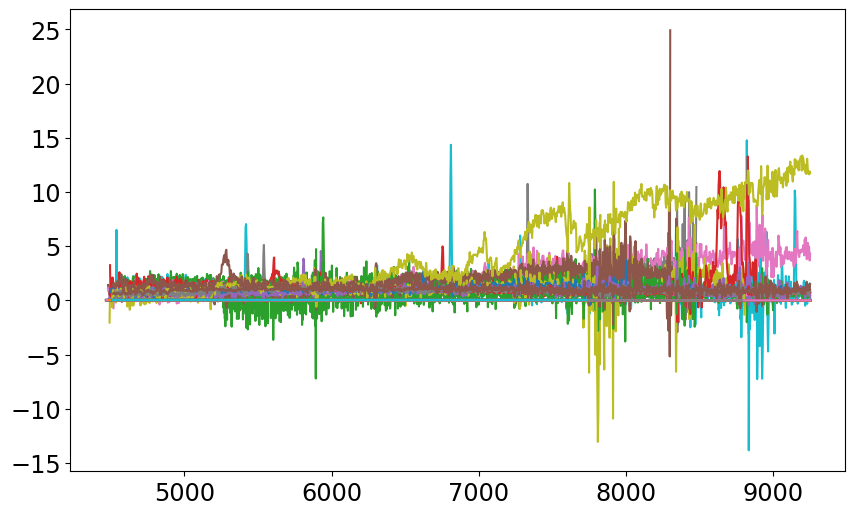

In [21]:
N = len(all_df)
fig = plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)
for idx in range(N):
    ax.plot(all_df[idx]["wl"], all_df[idx]["fl"])
    

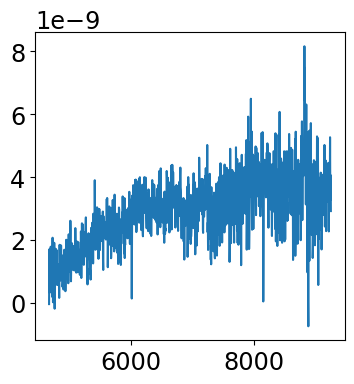

In [22]:
plt.plot(all_df[0]["wl"], all_df[0]["fl"])